In [1]:
import cv2
import mediapipe as mp
import numpy as np
import logging
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch

# Setup the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Running on device: {device}')

class DetectionPipeline:
    """Class for detecting faces in the frames of a video file using mediapipe."""
    
    def __init__(self, n_frames=20, resize=0.5, margin = 60):
        """Initialize with settings for face detection."""
        self.n_frames = n_frames
        self.margin = margin
        self.resize = resize
        self.face_detection = mp.solutions.face_detection.FaceDetection(
            min_detection_confidence=0.5)
        logging.basicConfig(level=logging.INFO)

    def get_sample_indices(self, v_len):
        """Calculate frame indices to sample based on video length."""
        if self.n_frames is not None:
            return np.linspace(0, v_len - 1, self.n_frames, dtype=int)
        return np.arange(v_len)    # Initialization and other methods

    def __call__(self, filename):
        """Process a video file to detect faces."""
        v_cap = cv2.VideoCapture(filename)
        if not v_cap.isOpened():
            logging.error(f"Failed to open video file {filename}")
            return []

        v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
        logging.info(f"Video length: {v_len} frames")

        sample_indices = self.get_sample_indices(v_len)
        faces = self.process_frames(v_cap, sample_indices)

        v_cap.release()
        return faces  
        
    def process_video(self, filename, label):
        """Process 20 evenly spaced frames of the video to detect and extract faces with labels."""
        v_cap = cv2.VideoCapture(filename)
        all_faces = []
        total_frames = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
        indices = np.round(np.linspace(0, total_frames - 1, min(self.n_frames, total_frames))).astype(int)

        for frame_idx in indices:
            v_cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = v_cap.read()
            if ret:
                faces = self.process_frame(frame)
                all_faces.extend([(face, label) for face in faces])  # Pair each face with the label

        v_cap.release()
        return all_faces
    

    def process_frames(self, v_cap, sample_indices):
        """Process selected frames using sample indices and detect faces."""
        faces = []
        for index in tqdm(sample_indices, desc='Processing frames'):
            v_cap.set(cv2.CAP_PROP_POS_FRAMES, index)
            ret, frame = v_cap.read()
            if ret:
                detected_faces = self.process_frame(frame)
                faces.extend(detected_faces)  # assuming you want to collect faces
            else:
                logging.warning(f"Frame at index {index} could not be read.")
        return faces

    def process_frame(self, frame):
        """Process a single frame to detect faces and return cropped images of these faces."""
        if self.resize is not None:
            
            frame = cv2.resize(frame, (int(frame.shape[1] * self.resize), int(frame.shape[0] * self.resize)))
            

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = self.face_detection.process(frame_rgb)

        faces = []
        if results.detections:
            for detection in results.detections:
                bboxC = detection.location_data.relative_bounding_box
                ih, iw, _ = frame.shape
                x, y, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), \
                             int(bboxC.width * iw), int(bboxC.height * ih)
                
                # Expanding the bounding box by 40 pixels on each side
                x_expanded = max(0, x - self.margin)
                y_expanded = max(0, y - self.margin)
                w_expanded = min(iw - x_expanded, w + self.margin*2)
                h_expanded = min(ih - y_expanded, h + self.margin*2)
                
                # Crop the face region with the expanded bounding box
                face_img = frame[y_expanded:y_expanded + h_expanded, x_expanded:x_expanded + w_expanded]
                faces.append(face_img)
        
        return faces

Running on device: cuda


In [2]:

import pandas as pd
def collect_dataset(pipeline,filename):
    dataset = []
    data = pd.read_csv(filename)
    for _, row in tqdm(data.iterrows(),  total=data.shape[0]):
        video_path = row['path']
        label = row['label']
        extracted_faces = pipeline.process_video(video_path, label)
        dataset.extend(extracted_faces)
        
    return dataset

In [3]:


# Load facial recognition model
feature_extractor = InceptionResnetV1(pretrained='vggface2', device=device).eval()


In [4]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
import cv2

def create_numpy_dataset(dataset):
    faces = [cv2.resize(face, (224, 224)) for face, _ in dataset]  # Resize for consistency
    labels = [label for _, label in dataset]
    faces = np.array(faces, dtype=np.float32)
    labels = np.array(labels, dtype=int)
    np.save('faces.npy', faces)
    np.save('labels.npy', labels)

def create_torch_dataset(dataset):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    faces = [transform(face) for face, _ in dataset]
    labels = torch.tensor([label for _, label in dataset], dtype=torch.long)
    torch_dataset = TensorDataset(torch.stack(faces), labels)
    torch.save(torch_dataset, 'torch_dataset.pt')
    return torch_dataset


In [5]:
import pandas as pd

SCALE = 0.5
N_FRAMES = 2
MARGIN = 30



In [6]:

pipeline = DetectionPipeline(n_frames=N_FRAMES, resize=SCALE, margin=MARGIN)
dataset = collect_dataset(pipeline, 'balanced_train_data.csv')
torch_dataset = create_torch_dataset(dataset)


  0%|          | 0/1780 [00:00<?, ?it/s]

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


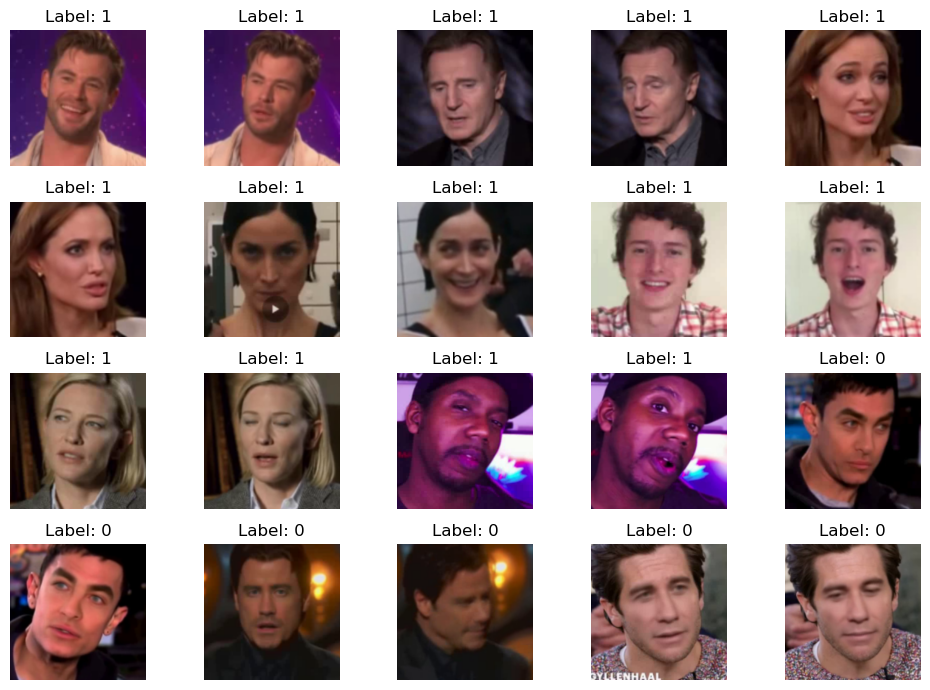

In [7]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Load the dataset from the .pt file
dataset = torch.load('torch_dataset.pt')

# Create a DataLoader
loader = DataLoader(dataset, batch_size=20)  # Loading 6 images
def show_images_grid(loader):
    for images, labels in loader:
        fig, axes = plt.subplots(4, 5, figsize=(10, 7))  # Set up a 2x3 grid
        axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration


        for img, label, ax in zip(images, labels, axes):
            print(img.shape)
            rgb_img = img[[2, 1, 0], :, :]  # Reorder the channels from BGR to R
            ax.imshow(rgb_img.permute(1, 2, 0))  # Adjust the channel dimension
            ax.set_title(f'Label: {label.item()}')
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()
        break  # Only show the first batch

# Call the function to display the images
show_images_grid(loader)